# Word Segmentation Modelling (version : alam.1.4)

This is the modelling documentation of Word Segmentation

First Structured :


Input :

    INPUT LENGTH =15
    TRAIN = 90k data (Random state : 342)
    WORD2VEC 50
    

output :

    Multi Conv LSTM


## Plan

    [*] Get Data
    [*] Transform the data
    [ ] Prepare the model
    [ ] Train it

In [6]:
%matplotlib inline
import sys
sys.path.append('../scr/')
import pandas as pd
import torch
import numpy as np
import os
import pickle
import WordSegmenTools as wst
from torch.autograd import Variable
import random
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
import time

In [7]:
PATH_DATA_RAW='../../data/raw/'
PATH_DATA_CLN='../../data/clean/'
PATH_MODEL='../../data/model/'

In [8]:
os.listdir(PATH_DATA_CLN)

['data_clean_100k.res']

In [9]:
os.listdir(PATH_MODEL)

['char_embed_25.res', 'char_embed_50.res', 'char_embed_75.res']

## Get Data

In [10]:
SEQ_LENGTH=15

In [11]:
# data_cln=pd.read_csv(PATH_DATA_CLN+'data_clean_100k.res')
data_cln=pickle.load(open(PATH_DATA_CLN+'data_clean_100k.res','rb'))
w2v = Word2Vec.load(PATH_MODEL+"char_embed_50.res")

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
data_cln['len_source']=data_cln.source.apply(len)
data_used=data_cln[data_cln.len_source==SEQ_LENGTH]
data_used=data_used.reset_index()[['source','target','index']]
data_used.columns=['source','target','ids']

In [13]:
data_used.sample(10)

,source,target,ids
17842,membeliitumasih,membeli itu masih,1483857
26698,maxindoaaibjuga,maxindo aaib juga,1525960
27679,sangatutamauang,sangat utama uang,1530459
37164,danbermainpecah,dan bermain pecah,1575969
84188,sepanjangtarget,sepanjang target,1798520
31142,dibumerangpapan,di bumerang papan,1547149
55525,channellainbaca,channel lain baca,1662834
13432,langsungbendera,langsung bendera,1462961
21461,sebelumnyauntuk,sebelumnya untuk,1501057
32547,hentikanlayanan,hentikan layanan,1553688


## Transform Data

In [14]:
data_used['flag_space'] = data_used['target'].map(wst.get_flag_space)
word2idx, idx2word = wst.get_label_index(data_used.source)

In [15]:
data_used_train=data_used.sample(90000,random_state=342)
data_used_test=data_used[~(data_used.ids.isin(data_used_train.ids))]

In [16]:
## Target 
Y_tr=np.array(data_used_train.flag_space.apply(list).tolist(),dtype=np.double)
Y_tr=Y_tr.reshape(-1,SEQ_LENGTH,1)
Y_te=np.array(data_used_test.flag_space.apply(list).tolist(),dtype=np.double)
Y_te=Y_te.reshape(-1,SEQ_LENGTH,1)

encoder = OneHotEncoder()
encoder.fit(Y_tr.reshape(-1,1))

Y_tr=encoder.transform(Y_tr.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))
Y_te=encoder.transform(Y_te.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))

## Source
X_tr=wst.char_vectorizer_word2vec(data_used_train.source.tolist(), w2v, SEQ_LENGTH)
X_te=wst.char_vectorizer_word2vec(data_used_test.source.tolist(), w2v, SEQ_LENGTH)

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [17]:
# word2idx

In [18]:
X_tr.shape

(90000, 15, 50)

In [19]:
X_te.shape

(10000, 15, 50)

In [20]:
Y_tr.shape

(90000, 15, 2)

## Prepare the Model

In [49]:
class ConvMultiLstm(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_dim0, hidden_dim1, Layers):        
        super(ConvMultiLstm, self).__init__()
        self.input_dim = input_size
#         self.input_cnn = input_cnn_size
        self.hidden_dim0 = hidden_dim0
        self.hidden_dim1 = hidden_dim1
        self.layer=Layers

        # self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.cnn1d = self.layer1 = torch.nn.Conv1d(in_channels=self.input_dim, out_channels=self.input_dim, kernel_size=5, stride=1, padding=2)
        self.act1 = torch.nn.ReLU()
        self.lstm1 = torch.nn.LSTM(self.input_dim, self.hidden_dim0)
#         self.lstm2 = torch.nn.LSTM(self.hidden_dim0, self.hidden_dim1)
        self.lstm3 = torch.nn.LSTM(self.hidden_dim0, self.hidden_dim0, num_layers=Layers)
        self.linear1 = torch.nn.Linear(self.hidden_dim0, self.hidden_dim1)
        self.linear2 = torch.nn.Linear(self.hidden_dim1, output_size)
        self.softmax = torch.nn.Softmax()
        
    def duplicate_tensor(self,X,n):
        X0=torch.cat((X, X), 0)
        for i in range(n-2):
            X0=torch.cat((X0, X), 0)
        return X0
        
    def forward(self, input):
        torch.manual_seed(200)
        batch_size=len(input)
        embedding_len=len(input[0][0])        
        input=input.view(batch_size,len(input[0]), -1)
        ## Transpose for cnn1d
        input_cnn=input.transpose(1, 2)
        cnn_out=self.cnn1d(input_cnn)
        
        ## Transpose for lstm
        input_lstm=cnn_out.transpose(1, 2)
        
        lstm_out, (hidden2_h,hidden2_c) = self.lstm1(input_lstm)
        hidden2_h_duplicate=self.duplicate_tensor(hidden2_h,self.layer)
        hidden2_c_duplicate=self.duplicate_tensor(hidden2_c,self.layer)
        
        out, hidden3 = self.lstm3(lstm_out,(hidden2_h_duplicate,hidden2_c_duplicate))
        y_pred = self.linear1(out)
        y_pred = self.linear2(y_pred)
        y_pred = self.softmax(y_pred)        
        return y_pred
    
## Remember LSTM : Batch, Seq, Embedding
## Conv : [batch_size, in_channels, Len Seq]
# p = p.transpose(1, 2).transpose(0, 1)

In [50]:
## Get the model
# INPUT_LENGTH=50
# LAYERS=3
# HIDDEN_LAYER0=100
# HIDDEN_LAYER1=20
# OUT_DIM=2
# learningRate=0.0004

# model_coba=MultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1, Layers=LAYERS)

In [51]:
# XX=torch.rand(2,8,50)
# model_coba(XX)

In [52]:
def data_batching_torch(X,y,batch):
    batches=[(torch.from_numpy(X[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'),
              torch.from_numpy(y[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'))   
                  for i in range(int(len(X)/batch)+1)]
    return batches

In [53]:
BATCH_SIZE=25
training_samples=data_batching_torch(X_tr,Y_tr,BATCH_SIZE)
len(training_samples)

3601

In [54]:
random.seed(100)
sample_val=random.sample(training_samples,540)
sample_train=list(set(training_samples)-set(sample_val))

In [55]:
# Get the model
INPUT_LENGTH=w2v.vector_size
LAYERS=2
HIDDEN_LAYER0=45
HIDDEN_LAYER1=15
OUT_DIM=2
learningRate=0.00045

model_clstm=ConvMultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1, Layers=LAYERS)

In [56]:
## Choose the optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_clstm.parameters(),lr=learningRate)
# optimizer = torch.optim.SGD(model.parameters(),lr=learningRate)

In [57]:
AA=training_samples[0][1]

In [58]:
AA.type()

'torch.DoubleTensor'

## Train it

In [59]:
epochs=175
model_clstm.double()
running_loss_train_ls=[]
running_loss_test_ls=[]

for epoch in range(epochs):
    L=time.time()
    model_clstm.train()
    running_loss_train = 0
    running_loss_test = 0
    # Converting inputs and labels to Variable
    
    for batch_idx, (data, target) in enumerate(sample_train, 1):
        if data.size()[0]>0:
            inputs = Variable(data)
            labels = Variable(target)
            optimizer.zero_grad()
            outputs= model_clstm(inputs)
            
            # get loss for the predicted output
            loss = criterion(outputs, labels)
            loss.backward()
            
            # update parameters
            optimizer.step()
            running_loss_train += (loss.item() - running_loss_train) / batch_idx
            
    model_clstm.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(sample_val, 1):
            if data.size()[0]>0:
                inputs = Variable(data)
                labels = Variable(target)
                outputs= model_clstm(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += (loss.item() - running_loss_test) / batch_idx
    
    running_loss_train_ls.append(running_loss_train)
    running_loss_test_ls.append(running_loss_test)
        
    if epoch % 7 == 0:
        print('----------'+str(epoch)+'----------')
        print("running loss train", running_loss_train)
        print("running loss val", running_loss_test)
        print("time every epoch: "+str((time.time()-L)/60))

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/ipykernel/__main__.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


----------0----------
running loss train 1.5579655862526085
running loss val 1.546835814158067
time every epoch: 1.9780471682548524
----------7----------
running loss train 1.5226626452928966
running loss val 1.5252250393231226
time every epoch: 1.9770416339238486
----------14----------
running loss train 1.5163886135748221
running loss val 1.5221576869873856
time every epoch: 1.9467247327168782
----------21----------
running loss train 1.5127255429674005
running loss val 1.5219393154358964
time every epoch: 1.9584757010142009
----------28----------
running loss train 1.5099688788617522
running loss val 1.5226164418401866
time every epoch: 1.968492579460144
----------35----------
running loss train 1.5076801205213706
running loss val 1.5246756886470167
time every epoch: 1.968402417500814
----------42----------
running loss train 1.5057005483361443
running loss val 1.5274285981784577
time every epoch: 2.0482490340868633
----------49----------
running loss train 1.5040105954637406
runnin

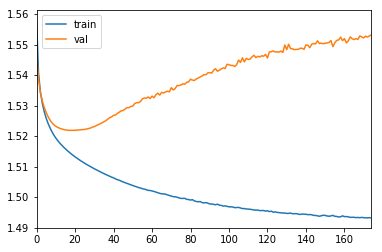

In [60]:
data_eval=pd.DataFrame({'train':running_loss_train_ls,'val':running_loss_test_ls})
data_eval.plot()

In [57]:
1+1

2

In [20]:
model.eval()

ModelLstm(
  (lstm): LSTM(26, 25)
  (linear): Linear(in_features=25, out_features=15, bias=False)
  (sigmoid): Sigmoid()
)

In [21]:
## Training
XX=X_tr.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [33]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [34]:
data_used_train['y_pred']=yy0

In [36]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
50144,melainkandaerah,melainkan daerah,1637189,000000001000000,000000000000000
67640,menegaskantiket,menegaskan tiket,1719973,000000000100000,000000000000000
87884,pelakusetiapini,pelaku setiap ini,1815936,000001000001000,000000000000000
32800,tahunberbobotdi,tahun berbobot di,1554907,000010000000100,000000000000000
60884,terpopulerdalam,terpopuler dalam,1687901,000000000100000,000000000000000
15182,identikinisudah,identik ini sudah,1471301,000000100100000,000000000000000
65497,denganpekerjaan,dengan pekerjaan,1709857,000001000000000,000000000000000
48114,mobiltahunsedan,mobil tahun sedan,1627587,000010000100000,000000000000000
58791,terkaitterhadap,terkait terhadap,1678152,000000100000000,000000000000000
31506,sertatariftahap,serta tarif tahap,1548878,000010000100000,000000000000000


## Test it

In [37]:
## Test it
XX=X_te.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [38]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [39]:
data_used_test['y_pred']=yy0

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
12342,sepakperusahaan,sepak perusahaan,1457750,000010000000000,000000000000000
9138,miliarmelakukan,miliar melakukan,1442854,000001000000000,000000000000000
3403,asalpendaftaran,asal pendaftaran,1416167,000100000000000,000000000000000
74342,jelasnyastadium,jelasnya stadium,1751813,000000010000000,000000000000000
12597,cmnphargaplakat,cmnp harga plakat,1459043,000100001000000,000000000000000
86940,bahwadenganyang,bahwa dengan yang,1811573,000010000010000,000000000000000
54344,terjadibniingin,terjadi bni ingin,1657235,000000100100000,000000000000000
8989,untuktetappiper,untuk tetap piper,1442103,000010000100000,000000000000000
15108,ratelalusamping,rate lalu samping,1471008,000100010000000,000000000000000
28477,danyangnokiadwi,dan yang nokia dwi,1534286,001000100001000,000000000000000
